In [1]:
import pickle
from random import shuffle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from pyts.image import MarkovTransitionField as MTF
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# метки классов по порогу
def labels_pred(pred_proba_1, threshold=0.5):
    _labels_pred = np.array(list(map(lambda x: 0 if x<threshold else 1, pred_proba_1)))
    return _labels_pred

# отчет по классификации
def report(y_true, y_prob, threshold=0.5):
    tn, fp, fn, tp = confusion_matrix(test_true, labels_pred(y_prob, threshold)).ravel()
    print(classification_report(test_true, labels_pred(y_prob, threshold)))
    print('---------------')
    print('Матрица ошибок:')
    print(confusion_matrix(y_true, labels_pred(y_prob, threshold)))
    print('---------------')
    print(f'Правильно предсказано 0: {tn}')
    print(f'Правильно предсказано 1: {tp}')
    print(f'Ложноотрицательных (FN, ош2р, пропуск события): {fn}')
    print(f'Ложноположительных (FP, ош1р, ложная  тревога): {fp}')
    print(f'Всего ошибок: {fp+fn}')

# калибровка порога
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Сlass 0', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Class 1', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

# Датасет

In [3]:
data_features = np.load('data_fragm.pkl',allow_pickle=True)
data_targets = np.load('data_param.pkl',allow_pickle=True)

data_features.shape, data_targets.shape

((49248, 7, 2000), (49248, 4))

In [4]:
data = list(zip(data_features,data_targets))
shuffle(data)

In [5]:
data_features = []
data_targets = []
for data_feature,data_target in data:
    data_features.append(data_feature)
    data_targets.append(data_target)
data_features = np.array(data_features)
data_targets = np.array(data_targets)

data_features.shape, data_targets.shape

((49248, 7, 2000), (49248, 4))

In [6]:
# переделка структуры данных
features = np.array([feature.T for feature in data_features])
features.shape

(49248, 2000, 7)

In [7]:
# переделка структуры данных с метками
labels = data_targets[:,3].astype(int)
labels.shape

(49248,)

### Пайплан данных

#### Масштабирование каналов от 0 до 1

In [8]:
def prepare_chanels(sample):
    scaler = MinMaxScaler()
    scaled_sample = scaler.fit_transform(sample)
    return scaled_sample.astype('float32')

features = np.array(list(map(prepare_chanels, features)))
features.shape

(49248, 2000, 7)

In [48]:
# параметры
TRAIN_SPLIT = 0.75
BATCH_SIZE = 50

split_index = int((features.shape[0] - 1) * TRAIN_SPLIT)

In [49]:
# пайплайн тренировочной выборки
train_features = tf.data.Dataset.from_tensor_slices(features[:split_index])
train_labels = tf.data.Dataset.from_tensor_slices(labels[:split_index])

train_ds = tf.data.Dataset.zip((train_features, train_labels))
train_ds = train_ds.shuffle(split_index).batch(BATCH_SIZE)

train_ds

<BatchDataset shapes: ((None, 2000, 7), (None,)), types: (tf.float32, tf.int32)>

In [50]:
# пайплайн тестовой выборки
test_features = tf.data.Dataset.from_tensor_slices(features[split_index:])
test_labels = tf.data.Dataset.from_tensor_slices(labels[split_index:])

test_ds = tf.data.Dataset.zip((test_features, test_labels))
test_ds = test_ds.batch(1)

test_ds

<BatchDataset shapes: ((None, 2000, 7), (None,)), types: (tf.float32, tf.int32)>

# Модель

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(14, 4, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool1D(2, 2),
    tf.keras.layers.Conv1D(28, 4, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool1D(2, 2),
    tf.keras.layers.Conv1D(35, 4, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool1D(2, 2),
    tf.keras.layers.Conv1D(42, 4, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool1D(2, 2),
    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Параметры обучения

In [52]:
bce = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=bce,
              metrics=['accuracy'])

### Обучение

In [53]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds)

Epoch 1/10
739/739 [==============================] - 119s 159ms/step - loss: 0.4638 - accuracy: 0.7593 - val_loss: 0.2714 - val_accuracy: 0.8900
Epoch 2/10
739/739 [==============================] - 122s 164ms/step - loss: 0.2720 - accuracy: 0.8895 - val_loss: 0.2426 - val_accuracy: 0.9071
Epoch 3/10
739/739 [==============================] - 116s 155ms/step - loss: 0.2425 - accuracy: 0.9029 - val_loss: 0.2279 - val_accuracy: 0.9163
Epoch 4/10
739/739 [==============================] - 117s 157ms/step - loss: 0.2171 - accuracy: 0.9126 - val_loss: 0.2111 - val_accuracy: 0.9150
Epoch 5/10
739/739 [==============================] - 117s 156ms/step - loss: 0.1943 - accuracy: 0.9248 - val_loss: 0.1972 - val_accuracy: 0.9246
Epoch 6/10
739/739 [==============================] - 117s 157ms/step - loss: 0.1817 - accuracy: 0.9290 - val_loss: 0.1810 - val_accuracy: 0.9336
Epoch 7/10
739/739 [==============================] - 128s 172ms/step - loss: 0.1617 - accuracy: 0.9395 - val_loss: 0.1654 -

### История loss

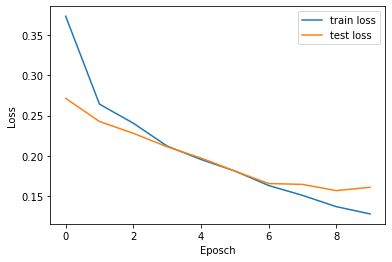

In [54]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.xlabel('Eposch')
plt.ylabel('Loss')
plt.show()

### История accuracy

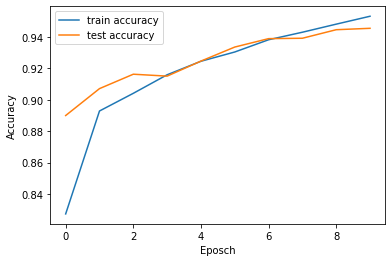

In [55]:
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.xlabel('Eposch')
plt.ylabel('Accuracy')
plt.show()

# Метрики

`test_true` - реальные метки классов

`test_pred` - вероятности класса 1

In [56]:
test_pred = model.predict(test_ds)
test_pred = test_pred.flatten()

test_true = labels[split_index:]

test_pred.shape, test_true.shape

((12313,), (12313,))

### ROC

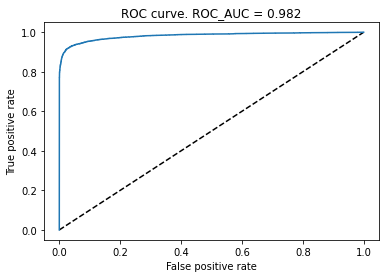

In [57]:
fpr, tpr, _ = roc_curve(test_true, test_pred)
roc_auc = roc_auc_score(test_true, test_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve. ROC_AUC = {roc_auc:.3f}')
plt.show()

### Калибровка порога

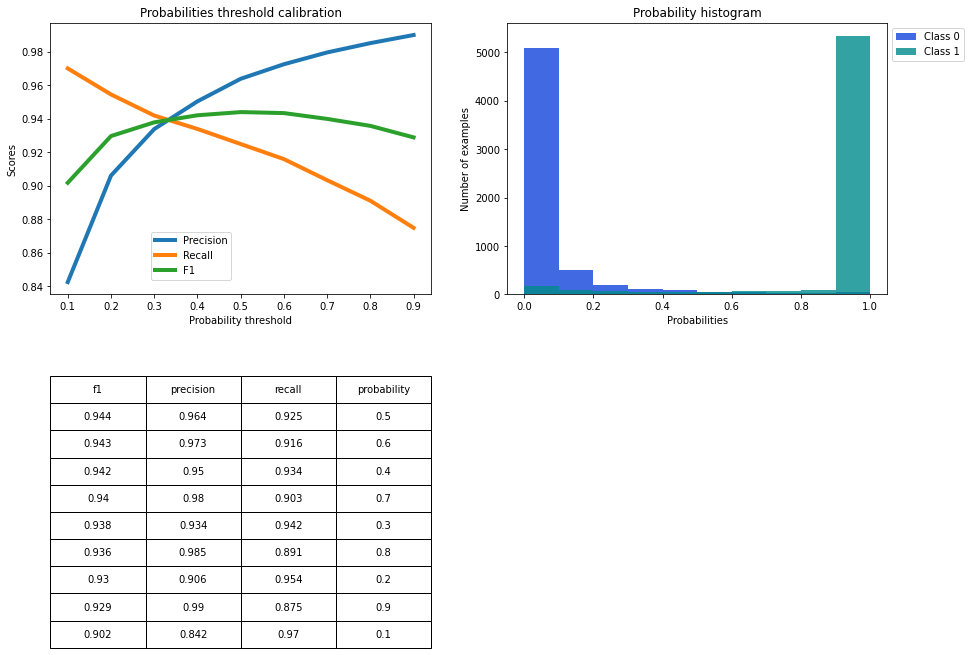

In [58]:
show_proba_calibration_plots(test_pred, test_true)

In [59]:
report(test_true, test_pred, 0.5)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6204
           1       0.96      0.92      0.94      6109

    accuracy                           0.95     12313
   macro avg       0.95      0.95      0.95     12313
weighted avg       0.95      0.95      0.95     12313

---------------
Матрица ошибок:
[[5992  212]
 [ 459 5650]]
---------------
Правильно предсказано 0: 5992
Правильно предсказано 1: 5650
Ложноотрицательных (FN, ош2р, пропуск события): 459
Ложноположительных (FP, ош1р, ложная  тревога): 212
Всего ошибок: 671


In [60]:
report(test_true, test_pred, 0.3)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6204
           1       0.93      0.94      0.94      6109

    accuracy                           0.94     12313
   macro avg       0.94      0.94      0.94     12313
weighted avg       0.94      0.94      0.94     12313

---------------
Матрица ошибок:
[[5796  408]
 [ 355 5754]]
---------------
Правильно предсказано 0: 5796
Правильно предсказано 1: 5754
Ложноотрицательных (FN, ош2р, пропуск события): 355
Ложноположительных (FP, ош1р, ложная  тревога): 408
Всего ошибок: 763


In [61]:
corrs = data_targets[:,2][split_index:]
corrs.shape

(12313,)

In [62]:
qs = data_targets[:,0][split_index:]
qs.shape

(12313,)

In [66]:
idx_fn = np.argwhere((test_true==1)&(labels_pred(test_pred,0.3)==1))

tp_corrs = corrs[idx_fn]

print('Правильно предсказано взрывов:', idx_fn.shape[0])
print('Предсказано взрывов с кор <0.6:', tp_corrs[tp_corrs<0.6].shape[0])
print('Доля', tp_corrs[tp_corrs<0.6].shape[0]/idx_fn.shape[0])

Правильно предсказано взрывов: 5754
Предсказано взрывов с кор <0.6: 1836
Доля 0.31908237747653806


In [67]:
idx_fn = np.argwhere((test_true==1)&(labels_pred(test_pred,0.3)==0))

tp_corrs = corrs[idx_fn]

print('Пропущенных взрывов:', idx_fn.shape[0])
print('Пропущенных взрывов с кор >=0.6:', tp_corrs[tp_corrs>=0.6].shape[0])
print('Доля', tp_corrs[tp_corrs<0.6].shape[0]/idx_fn.shape[0])

Пропущенных взрывов: 355
Пропущенных взрывов с кор >=0.6: 28
Доля 0.9211267605633803


In [68]:
idx_fn = np.argwhere((test_true==1)&(labels_pred(test_pred,0.5)==0))

tp_qs = qs[idx_fn]

unqs = np.unique(tp_qs, return_counts=True)
pd.DataFrame(unqs[1],unqs[0],columns=['Count'])

,Count
1.0,324
10.0,106
100.0,29


In [69]:
tf.saved_model.save(model,'classif_model')

INFO:tensorflow:Assets written to: classif_model\assets
